# Biodiversity Intactness Index change in Phoenix, AZ

**Author:** Jaslyn Miura

**GitHub Repository:** https://github.com/jaslynmiura/eds220-phoenix-biodiversity

## About

**Purpose**: Using rasters to understand the biodiversity of the Phoenix (AZ) subdivision between 2017 and 2020.

**Highlights**:
- Access and explore data from a SpatioTemporal Asset Catalog (STAC)
- Wrangle raster data
- Use raster algebra to calculate change
- Create a map of the Biodiversity Intactness Index

**About the Data**:
- Biodiversity Intactness Index (BII) Time Series: Retrieved from the Microsoft Planetary Computer STAC catalog, specifically the `io-biodiversity` collection. Datasets contain estimates of terrestrial Biodiversity Intactness as 100-meter gridded rasters for the years 2017-2020.
    - Date Accessed: December 4, 2025

- Phoenix Subdivision Shapefile: Retrieved from the United States Census Bureau, Geography Division. The dataframe contains census geometries for the state of Arizona
    - Date Accessed: November 19, 2025

**References**:

Impact Observatory (2017), Biodiversity Inactness[io-biodiversity]. Microsoft Planetary Computer STAC catalog. https://planetarycomputer.microsoft.com/dataset/io-biodiversity#overview on December 4, 2025.

U.S. Census Bureau, 2020 TIGER/Line Shapefiles: County[tl_2020_04_cousub], https://www.census.gov/cgi-bin/geo/shapefiles/index.php?year=2020&layergroup=County+Subdivisionsaccessed on December 4, 2025.


In [23]:
# Import necessary libraries
import os
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import rioxarray as rioxr
from shapely.geometry import Polygon
import contextily as ctx
import matplotlib.patches as mpatches

from pystac_client import Client  # To access STAC catalogs

import planetary_computer  # To sign items from the MPC STAC catalog 

from IPython.display import Image  # To nicely display images

## Explore Arizona Data

First, we'll do some basic data exploration such as viewing the head of the dataframe, checking the CRS, and looking for any NA values. This is an important step as we will need to know this information for data wrangling, our spatial analysis, and creating our maps.

In [ ]:
# Read in Arizona data
arizona = gpd.read_file(os.path.join('data',
                                     'tl_2020_04_cousub',
                                     'tl_2020_04_cousub.shp'))

In [25]:
# Using head() to view the first 5 rows of the arizona dataframe.
arizona.head(5)

,STATEFP,COUNTYFP,COUSUBFP,COUSUBNS,GEOID,NAME,NAMELSAD,LSAD,CLASSFP,MTFCC,CNECTAFP,NECTAFP,NCTADVFP,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
0,04,015,91964,02582914,0401591964,Lake Havasu City,Lake Havasu City CCD,22,Z5,G4040,None,None,None,S,7493863105,50863803,+34.7686221,-113.8749805,"POLYGON ((-114.48778 34.71722, -114.48622 34.7..."
1,04,007,91277,02582913,0400791277,Fort Apache,Fort Apache CCD,22,Z5,G4040,None,None,None,S,2134058292,4388167,+33.8847663,-110.3394452,"POLYGON ((-110.78327 34.16750, -110.78276 34.1..."
2,04,003,90306,01934923,0400390306,Bisbee,Bisbee CCD,22,Z5,G4040,None,None,None,S,1610943633,3494169,+31.4580397,-110.0783372,"POLYGON ((-110.46089 31.47376, -110.46089 31.4..."
3,04,003,90408,01934925,0400390408,Bowie,Bowie CCD,22,Z5,G4040,None,None,None,S,3556140749,1110460,+32.1699052,-109.3999964,"POLYGON ((-109.76866 32.30583, -109.76787 32.3..."
4,04,003,93825,01934992,0400393825,Willcox,Willcox CCD,22,Z5,G4040,None,None,None,S,1898081614,4959613,+32.1980984,-109.8877527,"POLYGON ((-110.15218 32.17203, -110.15213 32.1..."


In [26]:
print("The CRS of the arizona dataframe:", arizona.crs)

The CRS of the arizona dataframe: EPSG:4269


In [27]:
if arizona.crs.is_projected:
    print('arizona has a projected CRS')
else:
    print('arizona has a geographic CRS')

arizona has a geographic CRS


In [28]:
print("Number of NA values within each column:", arizona.isna().sum())

Number of NA values within each column: STATEFP      0
COUNTYFP     0
COUSUBFP     0
COUSUBNS     0
GEOID        0
NAME         0
NAMELSAD     0
LSAD         0
CLASSFP      0
MTFCC        0
CNECTAFP    80
NECTAFP     80
NCTADVFP    80
FUNCSTAT     0
ALAND        0
AWATER       0
INTPTLAT     0
INTPTLON     0
geometry     0
dtype: int64


**Arizona Data Description:**

After some data exploration of the arizona dataset, we've found that the data has a geographic CRS, EPSG:4269. From looking at the head of our dataframe we can see that the 'NAME' column contains county names, which will be helpful later as we want to filter our dataset to our study area, Phoenix. It should also be noted that we found some NA values within our data set in the 'CNECTAFP', 'NECTAFP', and 'NCTADVFP' columns. However, this should not cause problems within our analysis, as we will not be using these columns.

In [29]:
# Use the 'NAME' column to filter our data to just the Phoenix county.
phoenix = arizona[arizona['NAME'] == "Phoenix"]

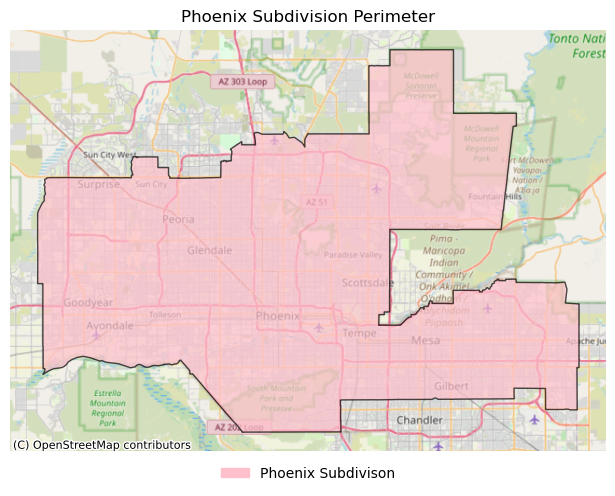

In [30]:
# Create a map of the Phoenix subdivision with a basemap.
fig, ax = plt.subplots()

phoenix.plot(ax=ax,
             alpha=0.7,
             color='pink',
             edgecolor='black')

# Add basemap using contextily
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik,
                crs=phoenix.crs)

# Create a label/legend for the areas of loss.
phoenix_label=mpatches.Patch(color='pink', 
                             label= 'Phoenix Subdivison')
ax.legend(handles=[phoenix_label], 
          loc='lower center',
          bbox_to_anchor=(0.5, -0.1),
          frameon=False)

ax.axis('off')

ax.set_title('Phoenix Subdivision Perimeter')

plt.tight_layout()

plt.show()

# STAC Data Access

To load the Biodiversity Intactness Index Time Series data we'll access the Microsoft Planetary Computer STAC catalog, then search for the `io-biodiversity` collection. By specifying a time, as `time_range` and area bounding box, as `bbox` within our search, this will return items of our study area within our time range.


In [31]:
# Access the MPC catalog
catalog = Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1", # url for the catalog
    modifier=planetary_computer.sign_inplace,
)

In [32]:
# Use `get_child()` with the catalog ID to get the single collection.
biodiversity_collection = catalog.get_child('io-biodiversity')

In [33]:
# Set the temporal range of interest.
time_range = "2017-01-01/2020-01-01"

# Set the bounding box.
bbox = [-112.826843, 32.974108, -111.184387, 33.863574]

# Catalog search, with time and area parameters.
search_biodiversity = catalog.search(
    collections = ['io-biodiversity'],
    bbox = bbox,
    datetime = time_range)
search_biodiversity

In [34]:
# Retrieve search items.
items_biodiversity = search_biodiversity.item_collection()
print(f"There are {len(items_biodiversity)} items within the catalog that matched our search")

There are 4 items within the catalog that matched our search


Since we have 4 items that matched our search, let's check the date times of each item to ensure we select the items, with the correct year of interest (2017 and 2020).

In [35]:
for item in items_biodiversity:
    print(item.properties['start_datetime'])

2020-01-01T00:00:00Z
2019-01-01T00:00:00Z
2018-01-01T00:00:00Z
2017-01-01T00:00:00Z


In [36]:
# Access raster data from the first item in the catalog seach which is year 2020
biodiversity2020 = rioxr.open_rasterio(items_biodiversity[0].assets['data'].href)

# Access raster data from item fourth item in the catalog seach which is year 2017
biodiversity2017 = rioxr.open_rasterio(items_biodiversity[3].assets['data'].href)

## Raster Data Exploration

Basic data exploration of rasters can be checking the CRS and whether the CRS is projected or geographic.

In [37]:
print('CRS of 20217 raster:', biodiversity2017.rio.crs)
print('CRS of 2020 raster:', biodiversity2020.rio.crs)

if biodiversity2017.rio.crs.is_projected:
    print('biodiversity2017 has a projected CRS')
else:
    print('biodiversity2017 has a geographic CRS')

if biodiversity2020.rio.crs.is_projected:
    print('biodiversity2020 has a projected CRS')
else:
    print('biodiversity2020 has a geographic CRS')

assert biodiversity2017.rio.crs == biodiversity2020.rio.crs

CRS of 20217 raster: EPSG:4326
CRS of 2020 raster: EPSG:4326
biodiversity2017 has a geographic CRS
biodiversity2020 has a geographic CRS


Simple data exploration of rasters includes checking the projection and CRS of the data. Our rasters both have the same geographic CRS. We also want to ensure that our `phoenix` data has the same CRS before we conduct any spatial analysis. Therefore, we'll reproject the `phoenix` data to match our rasters.

In [38]:
# Change the CRS of phoenix to match the biodiversity rasters.
phoenix = phoenix.to_crs(biodiversity2017.rio.crs)
assert biodiversity2017.rio.crs == phoenix.crs

## Spatial Analysis

After checking that our datasets have the same CRS, we can conduct our spatial analysis. First, we want to clip our rasters to the `phoenix` shape. This will return a raster to the shape of our area of interest, the Phoenix subdivision.

In [39]:
# Clip rasters to the phoenix shape.
phoenix_raster_2020 = biodiversity2020.rio.clip_box(*phoenix.total_bounds).rio.clip(phoenix.geometry)
phoenix_raster_2017 = biodiversity2017.rio.clip_box(*phoenix.total_bounds).rio.clip(phoenix.geometry)

#### Biodiversity Analysis

We want to calculate the percentage of area of the Phoenix subdivision with a Biodiversity Intactness of at least 0.75 in 2017 and 2020. We'll do this by creating new raster of each year that selects cells where this condition is true. Then by comparing these new rasters to the original rasters, we can calculate the percentage.

In [40]:
# Select cells of each raster where BII>=0.75
phoenix_raster_2020_loss = phoenix_raster_2020>=0.75
phoenix_raster_2017_loss = phoenix_raster_2017>=0.75

In [ ]:
# Calculating the percent area with a BII >= 0.75.
percent_2017 = (phoenix_raster_2017_loss.sum() / phoenix_raster_2017.count()) * 100
percent_2020 = (phoenix_raster_2020_loss.sum() / phoenix_raster_2020.count()) * 100

print(f"{percent_2017:.2f}% of area within the Phoenix subdivision with a BII of at least 0.75 in 2017")
print(f"{percent_2020:.2f}% of area within the Phoenix subdivision with a BII of at least 0.75 in 2020")

7.13% of area within the Phoenix subdivision with a BII of at least 0.75 in 2017
6.49% of area within the Phoenix subdivision with a BII of at least 0.75 in 2020


In [ ]:
# Identify cells where BII changed.
bio_loss = (phoenix_raster_2017_loss != phoenix_raster_2020_loss).astype(int)

# Change 0 values to NA values.
bio_loss = bio_loss.where(bio_loss, np.nan)

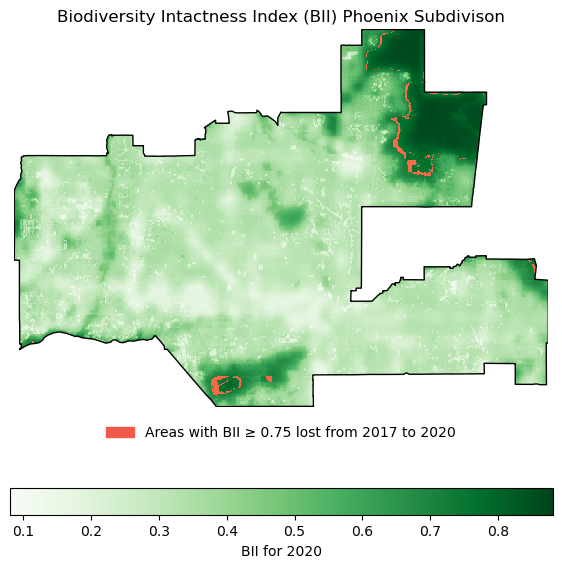

In [43]:
# Create map of 2020 biodiversity with loss from 2017.
fig, ax = plt.subplots(figsize=(10,7))

phoenix_raster_2020.plot(ax=ax,
                   cmap='Greens',
                   cbar_kwargs={
                        "shrink": 0.7,
                        "label": "BII for 2020",
                        "orientation": "horizontal"
    }
)

bio_loss.plot(ax=ax,
              add_colorbar=False,
              cmap='Reds'
)

# Create a label/legend for the areas of loss.
loss=mpatches.Patch(color='#F2594B', 
                    label= 'Areas with BII ≥ 0.75 lost from 2017 to 2020')
ax.legend(handles=[loss], 
          loc='lower center',
          bbox_to_anchor=(0.5, -0.12),
          frameon=False)

phoenix.plot(ax=ax,
             linewidth=1,
             color='none')

plt.title('Biodiversity Intactness Index (BII) Phoenix Subdivison')

ax.axis('off')

plt.show()

**Map Discussion:**

 this map we can see that the areas with a Biodiversity Intactness Index equal to or greater than 0.75 were lost from 2017 to 2020 are found along the regions or within the center of regions with a high BII. When referring to our subdivision perimeter plotted on a base map, we can see that regions with a high BII are reserves or parks. Since Phoenix is a large, densely populated city, it makes sense that we would find the highest Biodiversity Intactness Index in areas where species can find refuge from human infulences and impacts. Loss of Biodiversity Intactness Index along these regions, suggest that human anthorpogenic influence are encroaching on the natural habitats along these reserves and parks. The other highlighted area of biodiversity loss that appears to be within the center of a region with high biodiversity, can be an indicator of an invasive species introduction or disturbance that occured within the time range, that caused significant biodiversity loss.